# Exploring GEDI L4A data structure

This tutorial will explore data structure, variables, and quality flags of the [Global Ecosystem Dynamics Investigation (GEDI) L4a Footprint Level Aboveground Biomass Density (AGBD)](https://doi.org/10.3334/ORNLDAAC/1907) dataset. GEDI L4a Version 1 dataset is currently available for 2019-04-18 to 2020-09-02 and covers 52 North to 52 South latitudes. 

Details about the GEDI L4A dataset are available in the [User Guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density.html) and the [Algorithm Theoretical Basis Document (ATBD)](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_ATBD_L4A_v1.0.pdf). Please refer to other tutorials for [searching and downloading the GEDI L4A dataset](1_gedi_l4a_search_download.ipynb) and [subsetting GEDI L4a footprints by area of interest](2_gedi_l4a_subsets.ipynb).

## 1. Python modules
This tutorial will need the following python modules installed.

In [1]:
# import all the modules
import h5py
import tabulate
import contextily as ctx
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from IPython.display import HTML, display
from os import path
from shapely.geometry import Point
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.lines import Line2D
from matplotlib import cm
from matplotlib.colors import ListedColormap
from scipy import stats
plt.style.use('seaborn-whitegrid')

## 2. Example file
In this tutorial, we will use one GEDI L4A file, `GEDI04_A_2020207182449_O09168_T03028_02_001_01.h5`. The file can be downloaded directly from this link: https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/data/GEDI04_A_2020207182449_O09168_T03028_02_001_01.h5, which will require a [NASA EarthData account](https://urs.earthdata.nasa.gov/). We will go ahead and download the file directly from the link above and save it to the `full_orbits` directory. The file is `~924MB` in size. 

GEDI footprints data, including the Level 4A, are natively in [HDF5 format](https://earthdata.nasa.gov/esdis/eso/standards-and-references/hdf5), and each file represents one International Space Station (ISS) orbit. The file naming convention of the GEDI L4A is as below: 

- **GEDI04_A**: product short name 
- **YYYYDDDHHMMSS**: date and time of acquisition in Julian day of year, hours, minutes, and seconds format
- **OXXXXX**: orbit number
- **TXXXXX**: track number
- **P**: positioning and pointing determination system (PPDS) type (00: predict, 01: rapid, > 02: final)
- **R**: release number 001, representing the SOC SDS (software) release 
- **V**: production version

The GEDI L4A file `GEDI04_A_2020207182449_O09168_T03028_02_001_01.h5` represents orbit number `09168` and track number `03028` for the starting date-time in YYYYDDDHHMMSS format `2020207182449` or `2020-07-25 18:24:49 UTC`. The file has the PPDS type of `02`, which means it is final quality data. The file is a `Version 01 (Release 001)` product. 

## 3. Root Groups
Let's open this file using the `h5py` python library and print the root-level groups of the file.

In [2]:
# GEDI L4a file
l4a = 'GEDI04_A_2020207182449_O09168_T03028_02_001_01.h5'
l4af = path.join('full_orbits', l4a)
# read the L4A file
hf = h5py.File(l4af, 'r')
# printing root-level groups
list(hf.keys())

['ANCILLARY',
 'BEAM0000',
 'BEAM0001',
 'BEAM0010',
 'BEAM0011',
 'BEAM0101',
 'BEAM0110',
 'BEAM1000',
 'BEAM1011',
 'METADATA']

All science variables are organized by eight beams of the GEDI. Please refer to the [GEDI L4A user guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density.html) and [GEDI L4A data dictionary](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_L4A_Product_Data_Dictionary.pdf) for details. The root-level group also includes `ANCILLARY` and `METADATA` groups.

## 3. METADATA group
The `METADATA` group contains information about the file metadata. All the metadata attributes are provided in the `DatasetIdentification` group within `METADATA`. Let's print its content.

In [3]:
# read the METADATA group
metadata = hf['METADATA/DatasetIdentification']
# store attributes and descriptions in an array
data = []
for attr in metadata.attrs.keys():
    data.append([attr, metadata.attrs[attr]])

# display `data` array as a table
tbl_n = 1 # table number
print(f'Table {tbl_n}. Attributes and discription from `METADATA` group')
headers = ["attribute", "description"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 1. Attributes and discription from `METADATA` group


attribute,description
PGEVersion,001
VersionID,01
abstract,The GEDI L4A standard data product contains predictions of aboveground biomass density within each laser footprint.
characterSet,utf8
creationDate,2021-04-14T06:47:11.552806Z
credit,"The software that generates the L4A product was implemented at the Department of Geographical Sciences at the University of Maryland (UMD), in collaboration with the GEDI Science Data Processing System at the NASA Goddard Space Flight Center (GSFC) in Greenbelt, Maryland and the Institute at Brown for Environment and Society at Brown University."
fileName,GEDI04_A_2020207182449_O09168_T03028_02_001_01.h5
gedi_l4a_githash,f2b9da2f4962f050ab141323fbb06ec0f959d59e
language,eng
originatorOrganizationName,GSFC GEDI-SDPS > GEDI Science Data Processing System and University of Maryland


## 4. ANCILLARY group
The `ANCILLARY` group has three sub-groups - `model_data`, `pft_lut`, and `region_lut`.

In [4]:
# read the ANCILLARY group
ancillary = hf['ANCILLARY']
# print the subgroups
list(ancillary.keys())

['model_data', 'pft_lut', 'region_lut']

The `model_data` subgroup  contains information about parameters and variables from the L4A models used to generate predictions. The details about `model_data` variables are available in 'Table 6' of the [user guide](https://daac.ornl.gov/GEDI/guides/GEDI_L4A_AGB_Density.html). Let's print the `model_data` variables.

In [5]:
# read model_data subgroup
model_data = ancillary['model_data']
# print variables, data types, data dimension
model_data.dtype

dtype([('predict_stratum', 'O'), ('model_group', 'u1'), ('model_name', 'O'), ('model_id', 'u1'), ('x_transform', 'O'), ('y_transform', 'O'), ('bias_correction_name', 'O'), ('fit_stratum', 'O'), ('rh_index', 'u1', (8,)), ('predictor_id', 'u1', (8,)), ('predictor_max_value', '<f4', (8,)), ('vcov', '<f8', (5, 5)), ('par', '<f8', (5,)), ('rse', '<f4'), ('dof', '<u4'), ('response_max_value', '<f4'), ('bias_correction_value', '<f4'), ('npar', 'u1')])

Some `model_data` parameters have more than one dimension (e.g., `vcov`, which is the variance-covariance matrix of model parameters, has a dimension of 5 x 5). First, let's read all one-dimensional variables into a pandas dataframe.

In [6]:
# initialize an empty dataframe
model_data_df = pd.DataFrame()
# loop through parameters
for v in model_data.dtype.names:
    # exclude multidimensional variables
    if (len(model_data[v].shape) == 1):
        # copy parameters as dataframe column
        model_data_df[v] = model_data[v]
        # converting object datatype to string
        if model_data_df[v].dtype.kind=='O':
            model_data_df[v] = model_data_df[v].str.decode('utf-8') 

# print the parameters
tbl_n += 1
print(f'Table {tbl_n}. Parameters and their values in `model_data` subgroup')
model_data_df

Table 2. Parameters and their values in `model_data` subgroup


,predict_stratum,model_group,model_name,model_id,x_transform,y_transform,bias_correction_name,fit_stratum,rse,dof,response_max_value,bias_correction_value,npar
0,DBT_Af,4,DBT_Af,3,sqrt,sqrt,Snowdon,DBT_Af,1.950498,487,386.758881,1.092463,3
1,DBT_Au,4,EBT_Au,1,sqrt,sqrt,Snowdon,EBT_Au,2.923645,210,830.582031,1.017920,3
2,DBT_Eu,4,DBT_Eu,1,sqrt,sqrt,Snowdon,Eu,2.818270,747,724.057983,0.962632,3
3,DBT_NAs,4,DBT_coarse,1,sqrt,sqrt,Snowdon,DBT,2.661183,1695,724.057983,1.016632,3
4,DBT_SA,4,EBT_SA,1,sqrt,sqrt,Snowdon,EBT_SA,3.439619,3438,1578.000000,1.105528,3
5,DBT_SAs,4,EBT_coarse,1,sqrt,sqrt,Snowdon,EBT,3.920913,4811,1578.000000,1.113366,3
6,DBT_NAm,4,DBT_NAm,1,sqrt,sqrt,Snowdon,NAm,3.126976,2279,1768.699341,1.052422,3
7,EBT_Af,4,EBT_Af,1,sqrt,sqrt,Snowdon,EBT,3.920913,4811,1578.000000,1.113366,3
8,EBT_Au,4,EBT_Au,1,sqrt,sqrt,Snowdon,EBT_Au,2.923645,210,830.582031,1.017920,3
9,EBT_Eu,4,DBT_Eu,1,sqrt,sqrt,Snowdon,Eu,2.818270,747,724.057983,0.962632,3


The `predict_stratum` names are divided into two parts - the first part corresponding to PFTs and the second part to world regions. 
> **PFTs** (corresponding MCD12Q1 V006 classes are in parenthesis)    
`DBT`: deciduous broadleaf trees (Class 4), 
`DNT`: deciduous needleleaf trees (Class 3),
`EBT`: evergreen broadleaf trees (Class 2), 
`ENT`: evergreen needleleaf trees (Class 1),
`GSW`: grasses, shrubs and woodlands (Classes 5, 6, 11)

> **World Regions**   
`Af`: Africa, 
`Au`: Australia and Oceania, 
`Eu`: Europe, 
`NAm` : North America, 
`NAs`: North Asia, 
`SA`: South America,
`SAs` : South Asia

The information on PFTs and World Regions are also provided in `pft_lut` and `region_lut` groups within the `ANCILLARY` group.

In [7]:
# read pft_lut subgroup
pft_lut = ancillary['pft_lut']
headers = pft_lut.dtype.names
# print pft class and names
data = zip(pft_lut[headers[0]], pft_lut[headers[1]])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

pft_class,pft_name
1,ENT
3,DNT
2,EBT
4,DBT
5,GSW
6,GSW
11,GSW


In [8]:
# read region_lut subgroup
region_lut = ancillary['region_lut']
headers = region_lut.dtype.names
# print region class and names
data = zip(region_lut[headers[0]], region_lut[headers[1]])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

region_class,region_name
1,Eu
2,NAs
5,SAs
3,Au
4,Af
6,SA
7,NAm


In `Table 2` above, the `model_group` column represents model group:
>  **Model Group**   
`1`: all predictors considered, `2`: no RH metrics below RH50, `3`: forced inclusion of RH98, `4`: forced inclusion of RH98 and no RH metrics below RH50

`x_transform` and `y_transform` are predictor and response transform functions (e.g., `sqrt`, `log`). The column `bias_correction_name` specifies the bias correction methods used - Snowdon (1991) or Baskerville (1972). For details, please refer to Section 4.3 of the [ATBD](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_ATBD_L4A_v1.0.pdf).

To retrieve values from multidimensional variables, we can directly slice using the index from pandas dataframe `model_data_df`. For example, to print the variance-covariance matrix of the `DBT_NAm` prediction stratum (deciduous broadleaf trees North America, index=6), we can use:

In [9]:
# index of DBT_NAm predict_stratum, idx = 6
idx = model_data_df[model_data_df['predict_stratum']=='DBT_NAm'].index.item()
# print vcov matrix
model_data['vcov'][idx]

array([[ 4.19623613, -0.30473042, -0.09762442,  0.        ,  0.        ],
       [-0.30473042,  0.05645894, -0.02532849,  0.        ,  0.        ],
       [-0.09762442, -0.02532849,  0.03291459,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

Let's also print out the variables `predictor_id`, `rh_index`, and `par` for the `DBT_NAm` prediction stratum.

In [10]:
## get predictor_id, rh_index and par for idx = 6
predictor_id = model_data['predictor_id'][idx]
rh_index = model_data['rh_index'][idx]
par = model_data['par'][idx]

# print
print_s = f"""predictor_id: {predictor_id}
rh_index: {rh_index}
par: {par}"""
print(print_s)

predictor_id: [1 2 0 0 0 0 0 0]
rh_index: [50 98  0  0  0  0  0  0]
par: [-120.77709198    5.50771856    6.80801821    0.            0.        ]


The `predictor_id` variable gives the identifier of the predictor variable. The same consecutive predictor values indicate that the product of two metrics was used in the linear model. The variable `rh_index` gives the index of the relative height (RH) metrics used as predictors. For `DBT_NAm` stratum, two predictors `RH50` and `RH98` were used. The variable `par` gives model coefficients - the first element of the list is always the intercept of the linear model. 

We can use the values from these three variables (`predictor_id`, `rh_index`, and `par`) to construct the linear AGBD model for each prediction strata. Refer to [GEDI_L4A_Common_Queries](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_L4A_Common_Queries.pdf) for more information on how to assign coefficients and predictor variables to the linear models.

In [11]:
# initialize arrays
stratum_arr, modelname_arr, fitstratum_arr, agbd_arr = [], [], [], []
# loop the model_data_df dataframe
for idx, row in model_data_df.iterrows():
    stratum_arr.append(model_data_df['predict_stratum'][idx])
    modelname_arr.append(model_data_df['model_name'][idx])
    fitstratum_arr.append(model_data_df['fit_stratum'][idx])
    i_0 = 0
    predictor_id = model_data['predictor_id'][idx]
    rh_index = model_data['rh_index'][idx]
    par = model_data['par'][idx]
    model_str = 'AGBD = ' + str(par[0]) # intercept
    for i in predictor_id[predictor_id>0]:
        # use product of two RH metrics when consecutive 
        # predictor_id have same values
        if (i == i_0):
            model_str += ' x RH_' + str(rh_index[i-1])
        # adding slope coefficients
        else:
            model_str += ' + ' + str(par[i]) + ' x RH_' + str(rh_index[i-1])
        i_0 = i
    # agbd model
    agbd_arr.append(model_str)

# unique agbd models
unique_models = list(set(agbd_arr))

# printing agbd models by predict_stratum
data=[]
for model in unique_models:
    s, m, f = [], [], []
    for i, x in enumerate(agbd_arr):
        if x == model:
            s.append(stratum_arr[i])
            m.append(modelname_arr[i])
            f.append(fitstratum_arr[i])
    data.append([", ".join(s), ", ".join(list(set(m))), ", ".join(list(set(f))), model])
tbl_n += 1
print(f'Table {tbl_n}. AGBD Linear Models by Prediction Stratum')
headers = ["predict_stratum", "model_name", "fit_stratum", "AGBD model"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html', stralign="left")))

Table 3. AGBD Linear Models by Prediction Stratum


predict_stratum,model_name,fit_stratum,AGBD model
"DBT_NAs, EBT_NAs",DBT_coarse,DBT,AGBD = -110.05912780761719 + 5.133802890777588 x RH_60 + 6.171630382537842 x RH_98
"GSW_Af, GSW_Eu, GSW_NAs, GSW_SA, GSW_SAs, GSW_NAm",GSW_coarse,GSW,AGBD = -124.83228302001953 + 12.426309585571289 x RH_98
"DBT_Eu, EBT_Eu, ENT_Eu, DNT_Eu","DBT_Eu, ENT_Eu",Eu,AGBD = -96.53070068359375 + 7.175395488739014 x RH_70 + 2.9214682579040527 x RH_98
"ENT_Af, ENT_NAs, ENT_SA, ENT_SAs, DNT_Af, DNT_NAs, DNT_SA, DNT_SAs",ENT_coarse,ENT,AGBD = -118.41133880615234 + 7.776707172393799 x RH_60 + 4.377904415130615 x RH_98
"ENT_NAm, DNT_NAm",ENT_NAm,ENT,AGBD = -114.35456848144531 + 8.400657653808594 x RH_70 + 3.3459579944610596 x RH_98
"DBT_NAm, EBT_NAm",DBT_NAm,NAm,AGBD = -120.77709197998047 + 5.507718563079834 x RH_50 + 6.808018207550049 x RH_98
"DBT_Au, EBT_Au",EBT_Au,EBT_Au,AGBD = -155.41419982910156 + 7.816701889038086 x RH_70 + 7.7095465660095215 x RH_98
"DBT_SAs, EBT_Af, EBT_SAs","EBT_coarse, EBT_Af",EBT,AGBD = -104.9654541015625 + 6.802174091339111 x RH_50 + 3.9553122520446777 x RH_98
DBT_Af,DBT_Af,DBT_Af,AGBD = -118.40806579589844 + 1.956794023513794 x RH_50 + 9.96180534362793 x RH_98
"DBT_SA, EBT_SA",EBT_SA,EBT_SA,AGBD = -134.77015686035156 + 6.653591632843018 x RH_50 + 6.687118053436279 x RH_98


As we see in the table above, some predict strata share the same AGBD model. There are a total of 12 AGBD models representing 35 prediction strata.

## 5. BEAM groups
GEDI [instrument](https://gedi.umd.edu/instrument/specifications/) has two full-power lasers, each producing two beams and one coverage laser producing four beams, generating a total of 8 beams. GEDI L4A data are grouped by these beams (group name starting with `BEAMXXXX`). Let's print the name and description of BEAM groups. Each of the beams is assigned `beam` and `channel` numbers.

In [12]:
data = []
# loop through the root groups
for v in list(hf.keys()):
    if v.startswith('BEAM'):
        beam = hf.get(v)
        b_beam = beam.get('beam')[0]
        channel = beam.get('channel')[0]
        data.append([v, hf[v].attrs['description'], b_beam, channel])

# print as a table
tbl_n += 1
print(f'Table {tbl_n}. GEDI Beams')
headers = ["beam name", "description", "beam", "channel"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 4. GEDI Beams


beam name,description,beam,channel
BEAM0000,Coverage beam,0,0
BEAM0001,Coverage beam,1,0
BEAM0010,Coverage beam,2,1
BEAM0011,Coverage beam,3,1
BEAM0101,Full power beam,5,2
BEAM0110,Full power beam,6,3
BEAM1000,Full power beam,8,4
BEAM1011,Full power beam,11,5


Let's look into the data structure of one of the beams, `BEAM0110`, a full-powered beam. All of the 8 beams have the same set of variables and variable groups.

In [13]:
# get BEAM0110
beam_str = 'BEAM0110'
beam0110 = hf[beam_str]

data = []
# loop over all the variables within BEAM0110 group
for v in beam0110.keys():
    var = beam0110[v]
    source = ''
    # if the key is a subgroup assign GROUP tag
    if isinstance(var, h5py.Group):
        data.append([v, 'GROUP', 'GROUP', 'GROUP'])
    # read source, description, units attributes of each variables
    else:
        if 'source' in var.attrs.keys():
            source = var.attrs['source']
        data.append([v, var.attrs['description'], var.attrs['units'], source])

# print all variable name and attributes as a table
tbl_n += 1
print(f'Table {tbl_n}. Variables within {beam_str} group')
headers = ["variable", "description", "units", "source"]
data = sorted(data, key=lambda x:x[3])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 5. Variables within BEAM0110 group


variable,description,units,source
agbd,Aboveground biomass density (Mg / ha),Mg / ha,
agbd_pi_lower,Lower prediction interval (see alpha attribute for the level),Mg / ha,
agbd_pi_upper,Upper prediction interval (see alpha attribute for the level),Mg / ha,
agbd_se,Aboveground biomass density (Mg / ha) prediction standard error,Mg / ha,
agbd_t,Model prediction in fit units,-,
agbd_t_se,Model prediction standard error in fit units (needed for calculation of custom prediction intervals),-,
algorithm_run_flag,The L4A algorithm is run if this flag is set to 1. This flag selects data which have sufficient waveform fidelity for AGBD estimation.,-,
l2_quality_flag,Flag identifying the most useful L2 data for biomass prediction,-,
l4_quality_flag,Flag simplifying selection of most useful biomass predictions,-,
predict_stratum,Character ID of the prediction stratum name for the 1 km cell,-,


'L2A' in the 'source' column indicates that the variable originates from the [GEDI Level 2A dataset](https://doi.org/10.5067/GEDI/GEDI02_A.001), which provides footprint level elevation and canopy height metrics. Let's look into each of the variables in more detail. The AGBD variables include `agbd`, `agbd_pi_lower`, `agbd_pi_upper`, `agbd_prediction`, `agbd_se`. The variable `delta_time` provides time for each shot. `shot_number` is a unique number assigned to each GEDI shot. Quality flags are included in `l2_quality_flag` and `l4_quality_flag`, among others. Geolocation of shots is provided in `lat_lowestmode`, `lon_lowestmode`, and `elev_lowestmode`. Let's use this information to plot the path of each of the eight beams. First, let's read the latitudes, longitudes, and time variables into a pandas dataframe.

In [14]:
# initialize lists
lat_l = []
lon_l = []
beam_n = []
time_l=[]

# loop over all base groups
for var in list(hf.keys()):
    if var.startswith('BEAM'):
        
        # reading lat, lon, time
        beam = hf.get(var)
        lat = beam.get('lat_lowestmode')[:] # latitude
        lon = beam.get('lon_lowestmode')[:] # longitude
        time = beam.get('delta_time')[:] # time
        
        # appending each beam into the array
        lat_l.extend(lat.tolist()) 
        lon_l.extend(lon.tolist()) 
        time_l.extend(time.tolist()) 
        
        # beam_n as a new column indicating beam number
        n = lat.shape[0] # number of shots in the beam group
        beam_n.extend(np.repeat(str(var), n).tolist())

# read the lists into a dataframe
l4adf = pd.DataFrame(list(zip(beam_n,lat_l,lon_l,time_l)), 
                     columns=["beam", "lat_lowestmode", "lon_lowestmode", "delta_time"])

# print the first few shots of the BEAM0110
l4adf[l4adf['beam']=='BEAM0110'].head()

,beam,lat_lowestmode,lon_lowestmode,delta_time
2229376,BEAM0110,-51.801104,-152.147253,8.093667e+07
2229377,BEAM0110,-51.801103,-152.146841,8.093667e+07
2229378,BEAM0110,-51.801102,-152.146428,8.093667e+07
2229379,BEAM0110,-51.801101,-152.146015,8.093667e+07
2229380,BEAM0110,-51.801099,-152.145602,8.093667e+07


 We can now plot each of the eight beams. The total number of shots (`n`) in each beam is shown in the parenthesis.

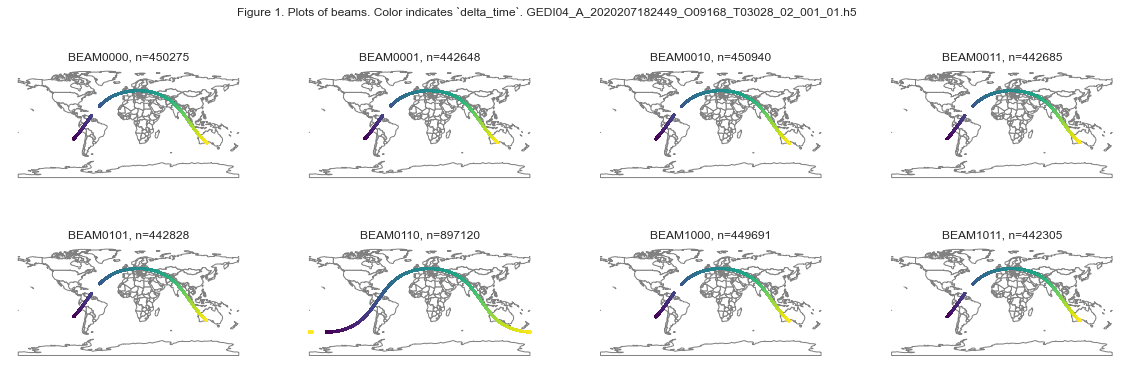

In [15]:
# first converting pandas dataframe into geopandas
l4agdf = gpd.GeoDataFrame(l4adf, 
                          geometry=gpd.points_from_xy(l4adf.lon_lowestmode, l4adf.lat_lowestmode))

# plot each beam as subplot
fig, axs = plt.subplots(nrows=2, ncols=4, sharex=True, sharey=True, figsize=(20,6))
fig_n = 1 # figure number
fig.suptitle(f'Figure {fig_n}. Plots of beams. Color indicates `delta_time`. {l4a}')
axs = axs.ravel()

# read world outline map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# loop over each beam
for i, beam in enumerate(l4adf.beam.unique()):
    base = world.plot(ax=axs[i], color='white', edgecolor='grey')
    subdf = l4agdf[l4agdf['beam'] == beam]
    
    # color the beam using delta_time
    subdf.plot(ax=base, column='delta_time', cmap='viridis', markersize=2)
    axs[i].set_title(f'{beam}, n={str(len(subdf.index))}')
    axs[i].axis('off')

As shown in Figure 1 above, all the beams are not always turned on, which results in different numbers of shots in each beam group.  The beams are usually always turned on over the land surface. The beam `BEAM0110` is turned on all the time for the orbit and has the most number of shots (`897,120`). This particular orbit scans from west to east, as indicated by the `delta_time` variable (blue being the minimum and yellow the maximum). 

The variable `delta_time` provides time for each shot in seconds since Jan 1 00:00 2018. We can convert the time to actual date and time using `datetime` module.

In [16]:
# datetime since
dt1 = datetime(2018, 1, 1, 0, 0, 0)
# min, max  and range datetime 
min_dt = dt1 + pd.to_timedelta(l4adf.delta_time.min(), unit='s') 
max_dt = dt1 + pd.to_timedelta(l4adf.delta_time.max(), unit='s') 
range_dt = max_dt - min_dt
# printing 
print_s = f"""Start time: {min_dt}
End time: {max_dt}
Total period: {range_dt}
Total shots: {len(l4adf.index)}"""
print(print_s)

Start time: 2020-07-25 18:24:31.003109
End time: 2020-07-25 19:57:22.996549
Total period: 1:32:51.993440
Total shots: 4018492


As shown above, the GEDI instrument acquired the first shot of this orbit at `2020-07-25 18:24:31.00` and the last shot at `2020-07-25 19:57:22.99`. In this `~1.5 hours` period, all eight beams recorded a total of `~4 million shots`!

To look at the spatial distribution of the GEDI shots,  let's zoom in to an area in the [Mount Leuser National Park](https://en.wikipedia.org/wiki/Mount_Leuser_National_Park) in Indonesia, where the orbit overpasses, and plot all the beams together. 

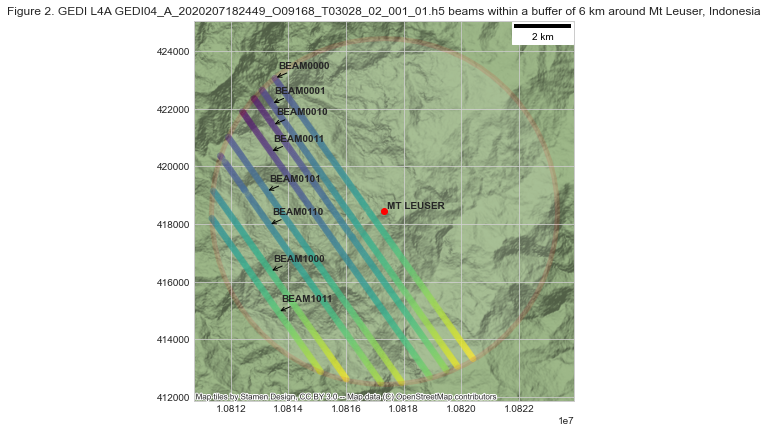

In [17]:
# Mt Leuser Buffer of 6km
mt_leuser_gdf= gpd.GeoSeries([Point((97.1736, 3.7563))])
mt_leuser_gdf.crs = "EPSG:4326"
mt_leuser_3857_gdf = mt_leuser_gdf.to_crs(epsg=3857)
mt_leuser_buffer = mt_leuser_3857_gdf.buffer(6000)

# assigning CRS of base map
l4agdf.crs = "EPSG:4326"
l4agdf_3857 = l4agdf.to_crs(epsg=3857)
# clipping the beam_var to the buffer
leuser_gdf = l4agdf_3857[l4agdf_3857['geometry'].within(mt_leuser_buffer.geometry[0])] 

# plotting the shots
ax = leuser_gdf.plot(alpha=0.3,  column='delta_time', cmap='viridis', figsize=(7, 7))
# plotting buffer circle
mt_leuser_buffer.plot(ax=ax,color='white', edgecolor='red', linewidth=5, alpha=0.1)
# plotting Mt Leuser
mt_leuser_3857_gdf.plot(ax=ax, color='red')

# Annotating Mt. Leuser
ax.annotate('MT LEUSER', xy=(mt_leuser_3857_gdf.geometry.x, mt_leuser_3857_gdf.geometry.y), 
            xytext=(3, 3), textcoords="offset points", weight='bold')
j = 0
for i, beam in enumerate(l4adf.beam.unique()):
    firstrow = leuser_gdf[leuser_gdf['beam']==beam].iloc[j]
    # Annotating the beam number
    ax.annotate(str(firstrow.beam), 
                xy=(firstrow.geometry.x, firstrow.geometry.y), 
                arrowprops=dict(arrowstyle="->"),
                xytext=(3, 10), textcoords="offset points", weight='bold')
    # display labels apart by 10
    j +=10
# scalebar
ax.add_artist(ScaleBar(1))
fig_n += 1
ax.set_title(f'Figure {fig_n}. GEDI L4A {l4a} beams within a buffer of 6 km around Mt Leuser, Indonesia')
#adding basemap
ctx.add_basemap(ax)

GEDI beams are ~600m apart across the track. The distance between the two outer beams is ~4.2 km.

Now, let's look at variables within one of the beam groups, `BEAM0110`, in more detail. We will read all the base variables within this beam group into a pandas dataframe.

In [18]:
# arrays to store variable names and values
var_names = []
var_val = []
# read BEAM0110
beam0110 = hf.get('BEAM0110')
# loop through all the items in BEAM0110 and append
# to the arrays var_names, var_val
for key, value in beam0110.items():
    if not isinstance(value, h5py.Group):
         # xvar variables have 2D
        if (key.startswith('xvar')):
            for r in range(4):
                var_names.append(key + '_' + str(r+1))
                var_val.append(value[:, r].tolist())
        else:
            var_names.append(key)
            var_val.append(value[:].tolist())

# create a pandas dataframe        
beam_df = pd.DataFrame(map(list, zip(*var_val)), columns=var_names) 
# set shot_number as dataframe index
beam_df = beam_df.set_index('shot_number')

Now, the `beam_df` dataframe contains all the variables within the BEAM0110 group. Let's convert it to a [geopandas](https://geopandas.org/) dataframe to assign spatial context. 

In [19]:
# convert to a geopandas dataframe for plotting
beam_gdf = gpd.GeoDataFrame(beam_df, geometry=gpd.points_from_xy(beam_df.lon_lowestmode, beam_df.lat_lowestmode))
# assigning CRS of WGS84
beam_gdf.crs = "EPSG:4326"
# turning fill values (-9999) to nan
beam_gdf = beam_gdf.replace(-9999, np.nan)

### 5.1 Prediction Stratum
Let's compute percent shots by the `predict_stratum` variable for the BEAM0110.

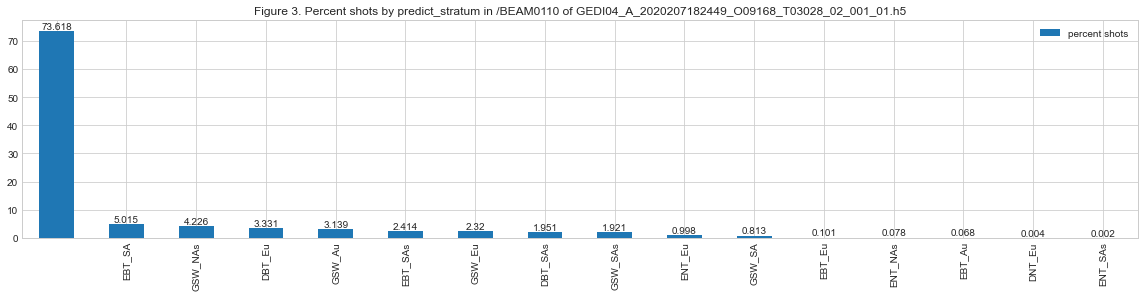

In [20]:
# percent shots in each predict_stratum
predict_stratum=beam_gdf.predict_stratum.str.decode('utf-8').value_counts(normalize=True).mul(100).round(3)
# plotting the values as bar diagram
ax = predict_stratum.plot(kind='bar', figsize=(20, 4))
ax.legend(["percent shots"])
fig_n += 1
ax.set_title(f'Figure {fig_n}. Percent shots by predict_stratum in {beam0110.name} of {l4a}')
# displaying values for each bar
for container in ax.containers:
    ax.bar_label(container)

This particular orbit passes through 15 different prediction strata, as shown in Figure 3, covering several forest regions of the world - from tropical forests of Amazons and SE Asia to temperate forests of Europe and arid regions of Australia. About 74% of the total shots have no prediction stratum assigned and are not in one of the 35 GEDI predict strata (e.g., water).

There are three sub-groups within each beam group indicated by 'GROUP' in Table 5 above - `agbd_prediction`, `geolocation`, and `land_cover_data`.

## 6.  Land Cover Group
The group `land_cover_data` within the beam group contains land cover information for the GEDI shots. Let's read all the variables within the `\BEAM0110\land_cover_data` group.

In [21]:
var_names = []
var_val = []
data = []

# loop through all variables within land_cover_data subgroup
for key, value in beam0110['land_cover_data'].items():
    var_names.append(key)
    var_val.append(value[:].tolist())
    data.append([key, value.attrs['description'], value.attrs['units'], value.attrs['source']])

# create a pandas dataframe        
beam_lc_df = pd.DataFrame(map(list, zip(*var_val)), columns=var_names) 
beam_lc_df = beam_lc_df.set_index('shot_number')

# join with the previous dataframe conaining root variables
# pandas will use `shot_number` as a common index to join
beam_gdf = beam_gdf.join(beam_lc_df)

# print variable description as table
tbl_n += 1
print(f'Table {tbl_n}. Variables within land_cover_data group')
headers = ["variable", "description", "units", "source"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 6. Variables within land_cover_data group


variable,description,units,source
landsat_treecover,"Tree cover in the year 2010, defined as canopy closure for all vegetation taller than 5m in height (Hansen et al.). Encoded as a percentage per output grid cell.",percent,L2A
landsat_water_persistence,The percent UMD GLAD Landsat observations with classified surface water between 2018 and 2019. Values > 80 usually represent permanent water while values < 10 represent permanent land.,percent,L2A
leaf_off_doy,GEDI 1 km EASE 2.0 grid leaf-off start day-of-year derived from the NPP VIIRS Global Land Surface Phenology Product.,days,L2A
leaf_off_flag,"GEDI 1 km EASE 2.0 grid flag derived from leaf_off_doy, leaf_on_doy and pft_class, indicating if the observation was recorded during leaf-off conditions in deciduous needleleaf or broadleaf forests and woodlands. 1 = leaf-off and 0 = leaf-on.",-,L2A
leaf_on_cycle,"Flag that indicates the vegetation growing cycle for leaf-on observations. Values are 0 (leaf-off conditions), 1 (cycle 1) or 2 (cycle 2).",-,L2A
leaf_on_doy,GEDI 1 km EASE 2.0 grid leaf-on start day-of-year derived from the NPP VIIRS Global Land Surface Phenology Product.,-,L2A
pft_class,GEDI 1 km EASE 2.0 grid Plant Functional Type (PFT) derived from the MODIS MCD12Q1v006 Product. Values follow the Land Cover Type 5 Classification scheme.,-,L2A
region_class,"GEDI 1 km EASE 2.0 grid world continental regions (0: Water, 1: Europe, 2: North Asia, 3: Australasia, 4: Africa, 5: South Asia, 6: South America, 7: North America).",-,L2A
shot_number,Shot number,-,L2A
urban_focal_window_size,The focal window size used to calculate urban_proportion. Values are 3 (3x3 pixel window size) or 5 (5x5 pixel window size).,pixels,l2A


All of the variables in the `land_cover_data` group originate from the GEDI L2A. Let's look at some key variables.

### 6.1 Plant Functional Types
The `pft_class` variable provides the plant functional types for the shots, which are derived from the MODIS land cover type product ([MCD12Q1](https://doi.org/10.5067/MODIS/MCD12Q1.006)). It uses `LC_Type5` or Annual PFT classification. Please refer to [Table 7](https://lpdaac.usgs.gov/documents/101/MCD12_User_Guide_V6.pdf) of the MCD12Q1 user guide for the PFT type legend. Let's plot distribution of shots by PFT class for the BEAM0110. 

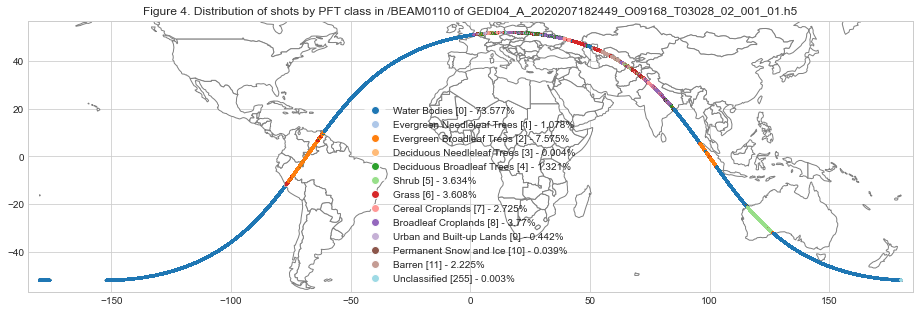

In [22]:
# percentage of shots by pft_class
pft_class=beam_gdf.pft_class.value_counts(normalize=True).mul(100).round(3).sort_index()

# MCD12Q1 PFT types
pft_legend = {'Water Bodies': 0, 'Evergreen Needleleaf Trees': 1, 'Evergreen Broadleaf Trees': 2, 
              'Deciduous Needleleaf Trees': 3, 'Deciduous Broadleaf Trees': 4, 'Shrub': 5, 'Grass': 6,
              'Cereal Croplands': 7, 'Broadleaf Croplands': 8, 'Urban and Built-up Lands': 9, 
              'Permanent Snow and Ice': 10, 'Barren' : 11, 'Unclassified': 255}
# get color from tab20
cmap = cm.get_cmap('tab20')
patchList = []
tab20 = []
# creating a legend
for key in pft_legend:
    i = pft_legend[key]
    label = f'{key} [{str(i)}] - {pft_class[i]}%'
    data_key = Line2D([0], [0], marker='o', color='w', label=label,
                          markerfacecolor=cmap(i), markersize=8)
    tab20.append(cmap(i))
    patchList.append(data_key)
newcmp = ListedColormap(tab20)

# compute bounds of beam_gdf
minx, miny, maxx, maxy = beam_gdf.total_bounds
# padding in degrees
pad = 5 
base = world.plot(color='white', edgecolor='grey', figsize=(20, 5))
ax=beam_gdf.plot(ax=base,column='pft_class', alpha=0.8, categorical=True, cmap=newcmp,
                 figsize=(20, 5), markersize=3, legend=True)
ax.set_xlim(minx-pad, maxx+pad)
ax.set_ylim(miny-pad, maxy+pad)
fig_n += 1
ax.set_title(f'Figure {fig_n}. Distribution of shots by PFT class in {beam0110.name} of {l4a}')
ax.legend(handles=patchList, loc='lower center', facecolor="white")

As we noted earlier (Figures 3 and 4), water bodies constitute ~74% of the total shots.

### 6.2 Urban Proportion
Another variable of interest is `urban_proportion`, which provides the proportion of urban land cover within the search area defined by `urban_focal_window_size` variable. The window size is defined as the number of pixels in the 25 m global urban mask [developed](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_ATBD_L4A_v1.0.pdf) by the GEDI science team using the TerraSAR-X and TanDEMX global urban footprint data products. 

(-56.80110406611274, 56.79322611235181)

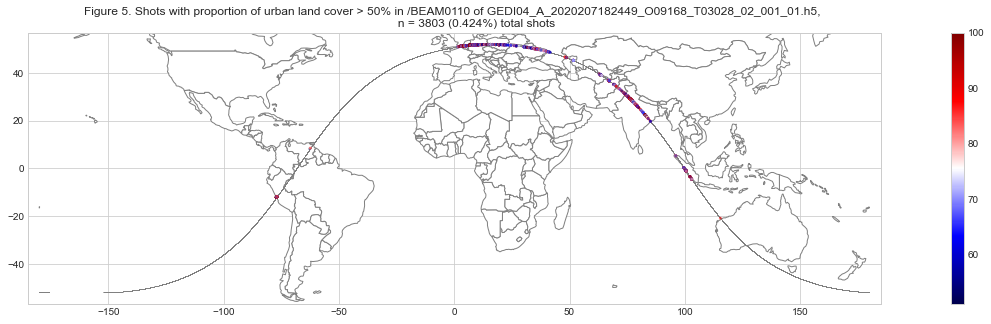

In [23]:
# subsetting the shots with urban cover > 50%
beam_urban_gdf = beam_gdf[beam_gdf['urban_proportion'] > 50]

# plotting the shots with urban cover > 50%
base = world.plot(color='white', edgecolor='grey', figsize=(25, 5))

ax = beam_gdf[beam_gdf['urban_proportion'] <= 50].plot(ax=base, color='grey', alpha=0.01, markersize=2, linewidth=0)
beam_urban_gdf.plot(ax=ax,column='urban_proportion', alpha=0.4, cmap='seismic', 
                 markersize=4, legend=True)

# figure title
n_urban = len(beam_urban_gdf.index)
percent_urban = (n_urban/len(beam_gdf.index)) * 100
fig_n += 1
ax.set_title(f'''Figure {fig_n}. Shots with proportion of urban land cover > 50% in {beam0110.name} of {l4a}, 
             n = {len(beam_urban_gdf.index)} ({round(percent_urban,3)}%) total shots''')
ax.set_xlim(minx-pad, maxx+pad)
ax.set_ylim(miny-pad, maxy+pad)

As shown in Figure 5, 0.424% of the total GEDI BEAM0110 shots falls over the urban areas (>50% urban cover). The shots with <=50% urban land cover is shown in the grey color.

### 6.3 Phenology

GEDI L4A footprints include phenology information derived from VIIRS/S-NPP Land Surface Phenology [VNP22Q2](https://doi.org/10.5067/VIIRS/VNP22Q2.001) in the variables `leaf_on_doy`, `leaf_off_doy` and `leaf_on_cycle`. These variables together with the PFT are used to indicate whether the GEDI shots were recorded during the leaf-off or leaf-on conditions, provided in the `leaf_off_flag`. When the shot is collected after the onset of maximum greenness  and before the midpoint of the senescence phase, they are marked with a flag of 1 (leaf-off). 

Let's plot the `leaf_off_flag` on a map. 

(-56.80110406611274, 56.79322611235181)

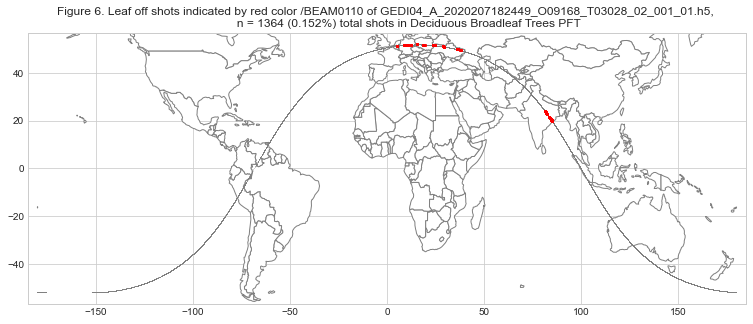

In [24]:
base = world.plot(color='white', edgecolor='grey', figsize=(25, 5))

# plotting leaf-on as grey
ax = beam_gdf[beam_gdf['leaf_off_flag']==0].plot(ax=base, color='grey', 
                                                 alpha=0.01, linewidth=0, markersize=2)
# plotting leaf-off as red
leaf_on_gdf =beam_gdf[beam_gdf['leaf_off_flag']==1]
leaf_on_gdf.plot(ax=ax, color='red', alpha=0.4, markersize=4)

# getting counts by pft_class
leaf_off=leaf_on_gdf.pft_class.value_counts()
# total shots with leaf-off
n_leaf_off = leaf_off.sum()
# pft classes of leaf-off shots
pft_leaf_off = ",".join([list(pft_legend.keys())[i] for i,v in leaf_off.items()])
# percent leaf off
percent_leaf_off = (n_leaf_off/len(beam_gdf.index)) * 100

# figure title
fig_n += 1
ax.set_title(f'''Figure {fig_n}. Leaf off shots indicated by red color {beam0110.name} of {l4a}, 
             n = {n_leaf_off} ({round(percent_leaf_off,3)}%) total shots in {pft_leaf_off} PFT''')
ax.set_xlim(minx-pad, maxx+pad)
ax.set_ylim(miny-pad, maxy+pad)

In Figure 6 above, the leaf-off shots are indicated with red. The GEDI orbit was collected on July 25, 2020. There were only 1364 shots with leaf-off conditions, all within the `Deciduous Broadleaf Trees` PFT.  

### 6.4 Tree Cover
GEDI uses Landsat-derived tree cover, which is defined as canopy closure for all vegetation taller than 5 m in height (Hansen et al., 2013). The following Figure 7 shows the percent tree cover.

(-56.80110406611274, 56.79322611235181)

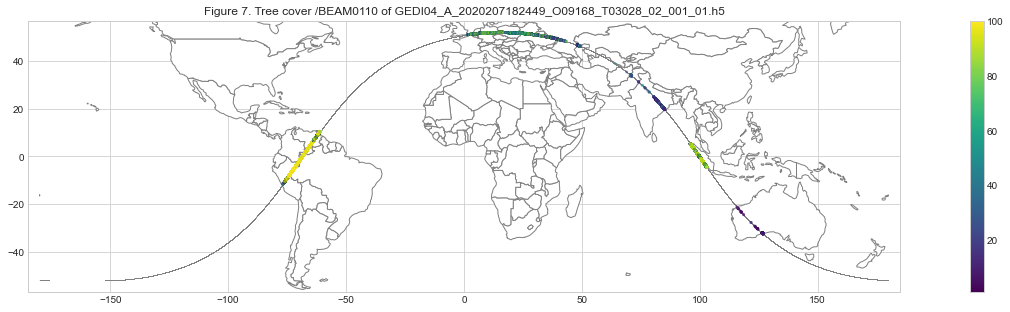

In [25]:
base = world.plot(color='white', edgecolor='grey', figsize=(25, 5))

ax = beam_gdf.plot(ax=base, color='grey', alpha=0.01, linewidth=0, markersize=2)
beam_gdf[beam_gdf['landsat_treecover'] != 0].plot(ax=ax, column='landsat_treecover', cmap='viridis',
                                                  alpha=0.4, markersize=4, legend=True)

# figure title
fig_n += 1
ax.set_title(f'''Figure {fig_n}. Tree cover {beam0110.name} of {l4a}''')
ax.set_xlim(minx-pad, maxx+pad)
ax.set_ylim(miny-pad, maxy+pad)

## 7. Geolocation Group
The `geolocation` subgroup within the BEAM group contains elevation, latitude, and longitude of the lowest mode for each of the seven algorithm settings groups. Canopy height metrics are computed relative to the elevation of the [lowest mode](https://doi.org/10.5067/DOC/GEDI/GEDI_WF_ATBD.001) or the last mode of the GEDI waveform. GEDI uses six different algorithm settings (`a1` to `a6`) for webform processing (refer to the [GEDI L1/L2 Waveform Processing ATBD, Table 5](https://doi.org/10.5067/DOC/GEDI/GEDI_WF_ATBD.001) for more details). Additional algorithm settings of `a10` in GEDI L4A indicate that `a5` has been used, but the lowest detected mode is likely noise. When this occurs, a higher mode was used to calculate RH metrics (see [GEDI L4A ATBD](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_ATBD_L4A_v1.0.pdf) for details).

The `geolocation` subgroup also provides a beam sensitivity metric for each of the seven algorithm settings. The sensitivity indicates signal strength of the GEDI shot to penetrate canopies and detect the true ground level. The subgroup also includes `stale_return_flag` (0=good) to indicate the signal quality. 

Let's read all the variables within the `\BEAM0110\geolocation` group.

In [26]:
var_names = []
var_val = []
data = []

# loop through all variables within land_cover_data subgroup
for key, value in beam0110['geolocation'].items():
    var_names.append(key)
    var_val.append(value[:].tolist())
    data.append([key, value.attrs['description'], value.attrs['units'], value.attrs['source']])

# create a pandas dataframe        
beam_geo_df = pd.DataFrame(map(list, zip(*var_val)), columns=var_names) 
beam_geo_df = beam_geo_df.set_index('shot_number')

# join with the previous dataframe conaining root variables
# pandas will use `shot_number` as a common index to join
beam_gdf = beam_gdf.join(beam_geo_df)

# print variable description as table
tbl_n += 1
print(f'Table {tbl_n}. Variables within geolocation group')
headers = ["variable", "description", "units", "source"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 7. Variables within geolocation group


variable,description,units,source
elev_lowestmode_a1,Elevation of center of lowest mode relative to reference ellipsoid,m,L2A
elev_lowestmode_a10,Elevation of center of lowest mode relative to reference ellipsoid,m,L2A
elev_lowestmode_a2,Elevation of center of lowest mode relative to reference ellipsoid,m,L2A
elev_lowestmode_a3,Elevation of center of lowest mode relative to reference ellipsoid,m,L2A
elev_lowestmode_a4,Elevation of center of lowest mode relative to reference ellipsoid,m,L2A
elev_lowestmode_a5,Elevation of center of lowest mode relative to reference ellipsoid,m,L2A
elev_lowestmode_a6,Elevation of center of lowest mode relative to reference ellipsoid,m,L2A
lat_lowestmode_a1,Latitude of center of lowest mode,degrees,L2A
lat_lowestmode_a10,Latitude of center of lowest mode,degrees,L2A
lat_lowestmode_a2,Latitude of center of lowest mode,degrees,L2A


## 8. AGBD variables

The `agbd` variable within the BEAM group contains estimated aboveground biomass density. Before looking further into `agbd` variables, let's go and read in the variables `agbd_prediction` subgroup. The `agbd_prediction` subgroup contains AGBD variables for all 7 algorithm settings groups (see Section 7 above). 

In [27]:
var_names = []
var_val = []

# loop through all variables within agbd_prediction subgroup
for key, value in beam0110['agbd_prediction'].items():
    # xvar variables have 2D
    if (key.startswith('xvar')):
        for r in range(4):
            var_names.append(key + '_' + str(r+1))
            var_val.append(value[:, r].tolist())
    else:
        var_names.append(key)
        var_val.append(value[:].tolist())

# create a pandas dataframe        
beam_agbd_df = pd.DataFrame(map(list, zip(*var_val)), columns=var_names) 
beam_agbd_df = beam_agbd_df.set_index('shot_number')

# join with the previous dataframe conaining root variables
# pandas will use `shot_number` as a common index to join
beam_gdf = beam_gdf.join(beam_agbd_df)

The `agbd_prediction` subgroup contains additional important prediction parameters used. Let's print the attributes and the values.

In [28]:
data = []
agbd_prediction = beam0110['agbd_prediction']
# loop through attributes
for attr in agbd_prediction.attrs.keys():
    data.append([attr, agbd_prediction.attrs[attr]])
# print attributes and values as table
tbl_n += 1
print(f'Table {tbl_n}. AGBD Prediction Attributes')
headers = ["Attributes", "value"]
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 8. AGBD Prediction Attributes


Attributes,value
alpha,0.1
l2a_alg_count,7
max_nvar,4
pft_grid_version,4
phenology_grid_version,5
predictor_offset,100
region_grid_version,5
response_offset,0
urban_grid_version,1
water_grid_version,1


In the table above, `predictor_offset` and `response_offset` are the offset appplied to predictors and response variables before fitting the AGBD model. The variable `alpha` is the alpha value used for calculation of prediction intervals. The AGBD models currently have maximum number of 4 predictors (`max_nvar`) and 7 algorithm settings groups (`l2a_alg_count`).

Now, let's plot the `agbd` variable for the BEAM0110 along the longitude axis.

(-184.9997124928771, 184.999877526202)

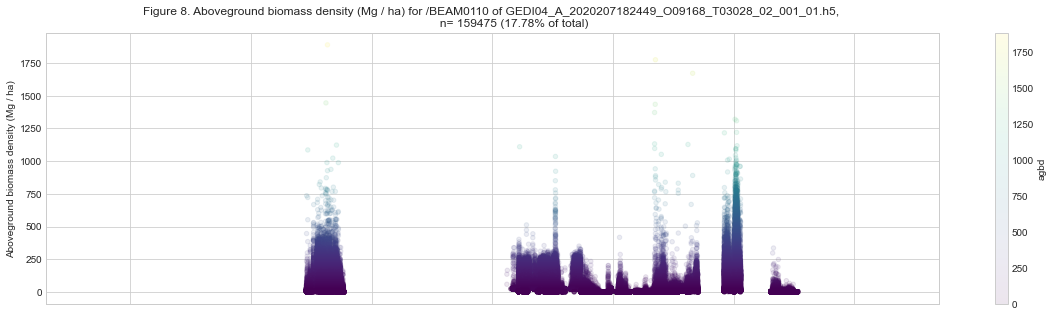

In [29]:
# compute bounds of beam_gdf
minx, miny, maxx, maxy = beam_gdf.total_bounds

# padding in degrees
pad = 5 
# x, y labels
ylabel = beam0110['agbd'].attrs['long_name'] + ' (' + beam0110['agbd'].attrs['units'] + ')'
xlabel = beam0110['lon_lowestmode'].attrs['long_name']

# subset where agbd is not null (-9999)
agbd_gdf = beam_gdf[~beam_gdf['agbd'].isnull()]

# plot
percent_agbd = (len(agbd_gdf.index)/len(beam_gdf.index))*100
ax = agbd_gdf.plot.scatter(x =['lon_lowestmode'], y=['agbd'],  cmap='viridis',  c='agbd',
                           alpha=0.1, ylabel=ylabel, xlabel=xlabel, figsize=(20, 5),
                           grid=True, legend=False)
fig_n += 1
ax.set_title(f'''Figure {fig_n}. {ylabel} for {beam0110.name} of {l4a}, 
             n= {len(agbd_gdf.index)} ({round(percent_agbd,2)}% of total)''')
ax.set_xlim([minx-pad, maxx+pad])

As shown in Figure 8 above, only 17.78% of the shots in BEAM0110 have `agbd` values. The shots over water surface and areas with no vegetation have no `agbd` values and are indicated with fill values of -9999. 

Let's also plot the `agbd` on a map. In the map below, the shots with no `agbd` values are indicated with grey dots. 

(-56.80110406611274, 56.79322611235181)

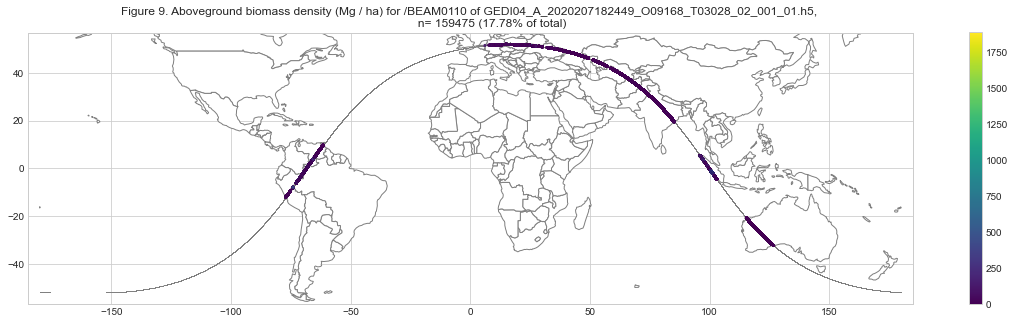

In [30]:
base = world.plot(color='white', edgecolor='grey', figsize=(20, 5))
ax = beam_gdf[beam_gdf['agbd'].isnull()].plot(ax=base, color='grey', alpha=0.01, linewidth=0, markersize=2)
beam_gdf.plot(ax=ax, column='agbd', cmap='viridis', alpha=0.4, markersize=4, legend=True)

fig_n += 1
ax.set_title(f'''Figure {fig_n}. {ylabel} for {beam0110.name} of {l4a}, 
             n= {len(agbd_gdf.index)} ({round(percent_agbd,2)}% of total)''')
ax.set_xlim(minx-pad, maxx+pad)
ax.set_ylim(miny-pad, maxy+pad)

Plotting thousands of shots from the `BEAM0110` in one figure may not show the variability in details. Let's subset the data into a smaller area for a closer look. We will subset an area in the [Mount Leuser National Park](https://en.wikipedia.org/wiki/Mount_Leuser_National_Park) in Indonesia, where the GEDI orbit overpasses. We will clip around 6 km from Mt. Leuser.

In [31]:
# Mt Leuser Buffer of 5km
mt_leuser_gdf= gpd.GeoSeries([Point((97.1736, 3.7563))])
mt_leuser_gdf.crs = "EPSG:4326"
mt_leuser_3857_gdf = mt_leuser_gdf.to_crs(epsg=3857)
mt_leuser_buffer = mt_leuser_3857_gdf.buffer(6000)

# assigning CRS of base map
beam_gdf_3857 = beam_gdf.to_crs(epsg=3857)
# clipping the beam_var to the buffer
leuser_gdf = beam_gdf_3857[beam_gdf_3857['geometry'].within(mt_leuser_buffer.geometry[0])] 
# plotting first few lines
leuser_gdf.head()

,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,agbd_t,agbd_t_se,algorithm_run_flag,beam,channel,degrade_flag,...,xvar_a4_3,xvar_a4_4,xvar_a5_1,xvar_a5_2,xvar_a5_3,xvar_a5_4,xvar_a6_1,xvar_a6_2,xvar_a6_3,xvar_a6_4
shot_number,,,,,,,,,,,,,,,,,,,,,
91680618300633705,NaN,NaN,NaN,NaN,NaN,NaN,0,6,3,1,...,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.0
91680618500633706,NaN,NaN,NaN,NaN,NaN,NaN,0,6,3,1,...,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.0,-9999.000000,-9999.000000,-9999.0,-9999.0
91680618700633707,55.617771,0.421164,203.532837,17.128305,7.067859,3.922277,1,6,3,1,...,0.0,0.0,10.310674,10.592922,0.0,0.0,10.057336,10.298059,0.0,0.0
91680619300633708,187.650787,47.486774,420.499054,17.121983,12.982439,3.921553,1,6,3,1,...,0.0,0.0,10.689247,11.437220,0.0,0.0,10.441743,11.184812,0.0,0.0
91680619500633709,255.015137,83.940132,518.769043,17.120995,15.134360,3.921440,1,6,3,1,...,0.0,0.0,10.914211,11.594396,0.0,0.0,10.296116,10.914211,0.0,0.0


The geopandas dataframe `leuser_gdf` contains all the variables within `BEAM0110` group for an area of 6 km around Mt. Leuser. Let's plot the shots on a map.

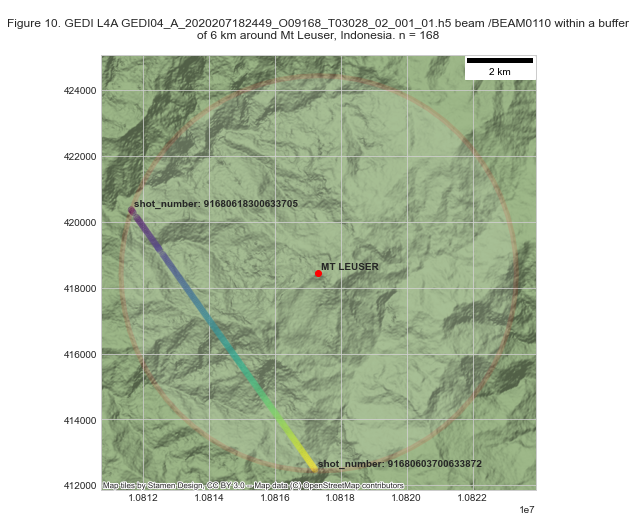

In [32]:
# plotting the shots
ax = leuser_gdf.plot(alpha=0.3,  column='delta_time', cmap='viridis',  figsize=(8, 8))
# plotting buffer circle
mt_leuser_buffer.plot(ax=ax,color='white', edgecolor='red', linewidth=5, alpha=0.1)
# plotting Mt Leuser
mt_leuser_3857_gdf.plot(ax=ax, color='red')

# Annotating Mt. Leuser
ax.annotate('MT LEUSER', xy=(mt_leuser_3857_gdf.geometry.x, mt_leuser_3857_gdf.geometry.y), 
            xytext=(3, 3), textcoords="offset points", weight='bold')
# Annotating the first shot_number
ax.annotate('shot_number: '+ str(leuser_gdf.iloc[0].name), 
            xy=(leuser_gdf.iloc[0].geometry.x, leuser_gdf.iloc[0].geometry.y), 
            xytext=(3, 3), textcoords="offset points", weight='bold')
# Annotating the last shot_number
ax.annotate('shot_number: '+ str(leuser_gdf.iloc[-1].name), 
            xy=(leuser_gdf.iloc[-1].geometry.x, leuser_gdf.iloc[-1].geometry.y), 
            xytext=(3, 3), textcoords="offset points", weight='bold')
# scalebar
ax.add_artist(ScaleBar(1))

# number modulus 100000000 gives last eight digits for shot number
# computing difference between the first and the last shot numbers
total_shots = (abs(leuser_gdf.iloc[-1].name) % 100000000) - \
               (abs(leuser_gdf.iloc[0].name) % 100000000)
# figure title
fig_n += 1
ax.set_title(f'''
Figure {fig_n}. GEDI L4A {l4a} beam {beam0110.name} within a buffer
of 6 km around Mt Leuser, Indonesia. n = {total_shots+1}
''')

#adding basemap
ctx.add_basemap(ax)

 The start and end shot numbers are also shown on the map. GEDI shot numbers are 18 characters and in the format `OOOOOBBFFFNNNNNNNN`, where:
- **OOOOO**: Orbit number
- **BB**: Beam number
- **FFF**: Minor frame number (0-241)
- **NNNNNNNN**: Shot number within orbit 

In Figure 10 above, the start shot has a value of `091680618300633705`, which means it is from the orbit number `09168`, the beam number `06`, the minor frame number of `183` and the shot number of `00633705` within the orbit. There are a total of 168 shots from beam `06` (or `BEAM0110`) within 6km of Mt. Leuser.

Now, let's plot the AGBD variables. 

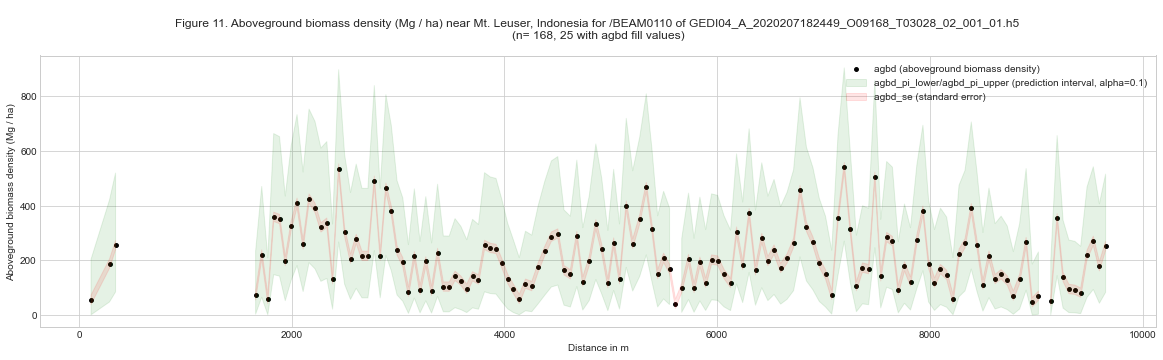

In [33]:
# compute the distance from the first point
leuser_gdf['distance'] = leuser_gdf.geometry.distance(leuser_gdf.iloc[0].geometry)
## x, y labels
ylabel = beam0110['agbd'].attrs['long_name'] + ' (' + beam0110['agbd'].attrs['units'] + ')'
xlabel = 'Distance in m'


# plotting agbd
ax = leuser_gdf.plot.scatter(x ='distance', y='agbd', s=15, ylabel=ylabel, xlabel=xlabel,
                        figsize=(20, 5), grid=True, color='black', 
                             label="agbd (aboveground biomass density)")
# figure title
fig_n += 1
ax.set_title(f'''
Figure {fig_n}. {ylabel} near Mt. Leuser, Indonesia for {beam0110.name} of {l4a} 
(n= {str(len(leuser_gdf.index))}, {len(leuser_gdf[leuser_gdf['agbd'].isnull()].index)} with agbd fill values)
''')

# getting alpha attribute from the agbd_prediction group
alpha =  beam0110['agbd_prediction'].attrs['alpha'] 
# plotting agbd_pi_upper/lower as fill area
ax.fill_between(leuser_gdf['distance'],  leuser_gdf['agbd_pi_lower'], leuser_gdf['agbd_pi_upper'], 
                alpha=0.1, color='green', 
                label="agbd_pi_lower/agbd_pi_upper (prediction interval, alpha=" + str(alpha) + ")" )

# plotting agbd_se as fill area
ax.fill_between(leuser_gdf['distance'],  leuser_gdf['agbd'] - leuser_gdf['agbd_se'], 
                leuser_gdf['agbd'] + leuser_gdf['agbd_se'], alpha=0.1, color='red', 
                label="agbd_se (standard error)")

ax.legend()

The `agbd` shows the selected aboveground biomass density, shown by black dots in Figure 11 above. The prediction standard error `agbd_se` is shown with a red-filled area. The upper and lower prediction intervals are shown with a green-filled area.

GEDI shots are ~60m apart along the track. In the figure above, there are ~16-17 shots (shown by dots) within a distance of 1000 m. Note that a total of 25 shots with `agbd` fill values (-9999) are not plotted. 

The above plot shows the AGBD estimates at alpha=0.1 (90% confidence interval), the default confidence interval used for these variables. To compute the estimates at a different confidence interval (e.g., 95%), we can use `agbd_t` and `agbd_t_se` variables, which provides the prediction in transform space. For more details, please refer to [GEDI L4A Common Queries](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_L4A_Common_Queries.pdf).

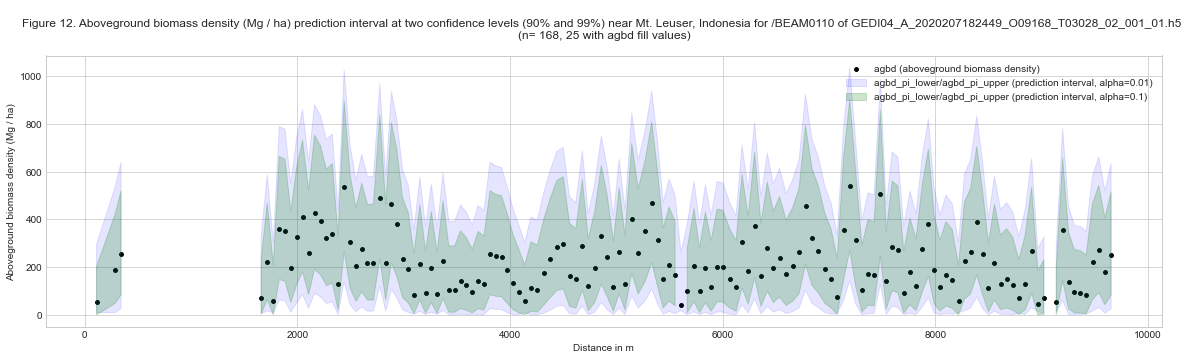

In [34]:
# 99% confidence interval
alpha_2 = 0.01
# degree of freedom for shots

leuser_gdf['predict_stratum'] = leuser_gdf['predict_stratum'].str.decode('utf-8')
for i, row in leuser_gdf.iterrows():
    # model_data_df dataframe from Section 4 above contains ancillary variables
    dof = model_data_df[model_data_df['predict_stratum']==row['predict_stratum']].dof.item()
    bias = model_data_df[model_data_df['predict_stratum']==row['predict_stratum']].bias_correction_value.item()
    leuser_gdf.at[i,'dof']=dof
    leuser_gdf.at[i,'bias_correction_value']=bias

leuser_gdf['agbd_pi_lower_2'] = (leuser_gdf['agbd_t'] - \
                                  (leuser_gdf['agbd_t_se'] * stats.t.ppf(1-(alpha_2/2), leuser_gdf['dof'])))**2 + \
                                    leuser_gdf['bias_correction_value']
leuser_gdf['agbd_pi_upper_2'] = (leuser_gdf['agbd_t'] + \
                                  (leuser_gdf['agbd_t_se'] * stats.t.ppf(1-(alpha_2/2), leuser_gdf['dof'])))**2 + \
                                    leuser_gdf['bias_correction_value']
# plotting agbd
ax = leuser_gdf.plot.scatter(x ='distance', y='agbd', s=15, ylabel=ylabel, xlabel=xlabel,
                        figsize=(20, 5), grid=True, color='black', 
                             label="agbd (aboveground biomass density)")
# figure title
fig_n += 1
ax.set_title(f'''
Figure {fig_n}. {ylabel} prediction interval at two confidence levels (90% and 99%) near Mt. Leuser, Indonesia for {beam0110.name} of {l4a} 
(n= {str(len(leuser_gdf.index))}, {len(leuser_gdf[leuser_gdf['agbd'].isnull()].index)} with agbd fill values)
''')

# getting alpha attribute from the agbd_prediction group
alpha =  beam0110['agbd_prediction'].attrs['alpha'] 
# plotting agbd_pi_upper/lower as fill area

ax.fill_between(leuser_gdf['distance'],  leuser_gdf['agbd_pi_lower_2'], leuser_gdf['agbd_pi_upper_2'], 
                alpha=0.1, color='blue', 
                label="agbd_pi_lower/agbd_pi_upper (prediction interval, alpha=" + str(alpha_2) + ")" )
ax.fill_between(leuser_gdf['distance'],  leuser_gdf['agbd_pi_lower'], leuser_gdf['agbd_pi_upper'], 
                alpha=0.2, color='green', 
                label="agbd_pi_lower/agbd_pi_upper (prediction interval, alpha=" + str(alpha) + ")" )


ax.legend()


As noted above in Section 7, the subgroup `agbd_prediction` provides AGBD estimates for all seven algorithm settings groups (a1-6 and a10). Let's plot all of them together. For clarity, we will plot selected shots in the following figure.

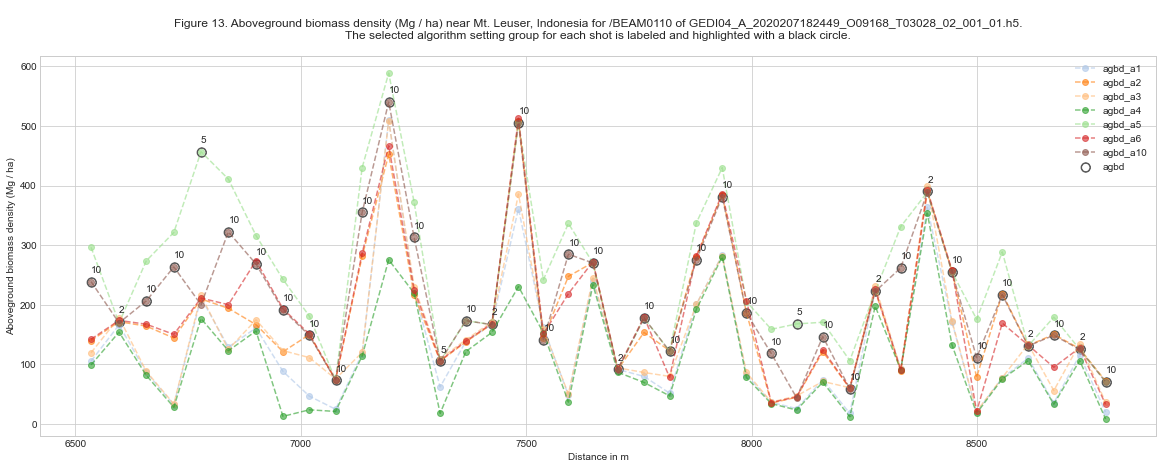

In [35]:
## x, y labels
ylabel = beam0110['agbd'].attrs['long_name'] + ' (' + beam0110['agbd'].attrs['units'] + ')'
xlabel = 'Distance in m'

# plotting agbd
ax = leuser_gdf[-55:-15].plot.scatter(x ='distance', y='agbd', s=100, ylabel=ylabel, xlabel=xlabel,
                        figsize=(20, 7), grid=True, marker = "$\u25EF$", alpha=0.5, color='black',
                             label="agbd")

l2a_alg_count =  beam0110['agbd_prediction'].attrs['l2a_alg_count'] 
for i in range(l2a_alg_count):

    if i == 6:
        i = 10
    else:
        i += 1
        
    agbd_aN = 'agbd_a' +  str(i)
    # plotting agbd
    leuser_gdf[-55:-15].plot.line(ax=ax, x ='distance', y=agbd_aN, ylabel=ylabel, xlabel=xlabel,
                            figsize=(20, 7), grid=True, color=cmap(i), style='--o', alpha=0.6,
                                 label=agbd_aN)
for i, row in leuser_gdf[-55:-15].iterrows():
    ax.annotate(row["selected_algorithm"], (row["distance"],row["agbd"]+15))

# figure title
fig_n += 1
ax.set_title(f'''
Figure {fig_n}. {ylabel} near Mt. Leuser, Indonesia for {beam0110.name} of {l4a}.
The selected algorithm setting group for each shot is labeled and highlighted with a black circle.
''')

ax.legend()

Figure 13 above shows the variability of the predicted biomass among the different algorithm setting groups.

## 9. Predictor variables

The `xvar` variable provides predictor variables. Let's print the number of shots per predict_stratum in the `leuser_gdf` subset.

In [36]:
leuser_gdf.predict_stratum.value_counts()

EBT_SAs    168
Name: predict_stratum, dtype: int64

As shown above, all the GEDI shots near Mt. Leuser is classified as `EBT_SAs` prediction stratum (`evergreen broadleaf trees` PFT and `South Asia` region). The AGBD prediction model for `EBT_SAs` is given in Table 3 above as: 
`AGBD = -104.9654541015625 + 6.802174091339111 x RH_50 + 3.9553122520446777 x RH_98`. 

The `xvar` variable has 4 columns, which we read into the dataframe above as `xvar_1`, `xvar_2`, `xvar_3`, and `xvar_4`. Let's print the columns.

In [37]:
tbl_n += 1
print(f'Table {tbl_n}. Predictor variables for the shots near Mt. Leuser, Indonesia for {beam0110.name} of {l4a}')
leuser_gdf[['xvar_1', 'xvar_2', 'xvar_3', 'xvar_4']]

Table 9. Predictor variables for the shots near Mt. Leuser, Indonesia for /BEAM0110 of GEDI04_A_2020207182449_O09168_T03028_02_001_01.h5


,xvar_1,xvar_2,xvar_3,xvar_4
shot_number,,,,
91680618300633705,NaN,NaN,NaN,NaN
91680618500633706,NaN,NaN,NaN,NaN
91680618700633707,10.310674,10.592922,0.0,0.0
91680619300633708,10.689247,11.437220,0.0,0.0
91680619500633709,10.914211,11.594396,0.0,0.0
...,...,...,...,...
91680602900633868,10.418734,10.784712,0.0,0.0
91680603100633869,10.807405,11.502173,0.0,0.0
91680603300633870,10.915586,11.711106,0.0,0.0


Since the linear model for `EBT_SAs` prediction stratum has only two predictor variables, `RH_50` and `RH_98`, the columns `xvar_3` and `xvar_4` in the above table are filled with zero values.

The `xvar` predictors are transformed and as well as offset applied. Table 3 above shows that square-root (`sqrt`) transformation is applied to the `EBT_SAs` prediction stratum both x- and y- variables, and a predictor offset (`predictor_offset`) of 100 are applied. We will need the offset and transformation to derive the true RH metric, and plot them along with `agbd` value.

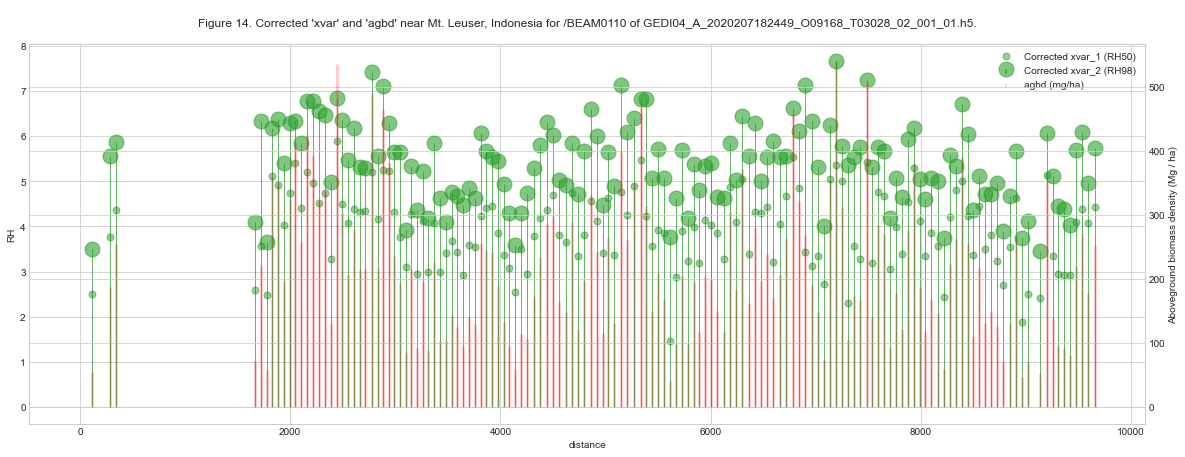

In [38]:
# deriving true RH metric
leuser_gdf['xvar_1_true']=np.sqrt((leuser_gdf['xvar_1'])**2-100)
leuser_gdf['xvar_2_true']=np.sqrt((leuser_gdf['xvar_2'])**2-100)

# plotting xvar_1_true (smaller green dots)
ax = leuser_gdf.plot.line(x ='distance', y='xvar_1_true', figsize=(20, 7), grid=True, color='green', 
                          style='o', alpha=0.4, markersize=7, label='Corrected xvar_1 (RH50)')

# adding xvar_2_true as stem plot (larger green dots)
markerline, stemline, baseline = ax.stem(leuser_gdf['distance'], leuser_gdf['xvar_2_true'], 
                                         linefmt='-g',markerfmt='C2o', basefmt='C2-',
                                        label='Corrected xvar_2 (RH98)')
plt.setp(stemline, linewidth = 1.0, alpha=0.6)
plt.setp(markerline, markersize = 15, alpha=0.6)
plt.setp(baseline, linewidth = 0)

# adding agbd in the secondary axis
ax2 = ax.twinx()
markerline, stemline, baseline = ax2.stem(leuser_gdf['distance'], leuser_gdf['agbd'], 
                                          linefmt='-r', markerfmt='C5o', basefmt='C2-',
                                        label='agbd (mg/ha)')
plt.setp(markerline, markersize = 0)
plt.setp(stemline, linewidth = 3.0, alpha=0.2)
plt.setp(baseline, linewidth = 0)
# figure title
fig_n += 1
ax.set_title(f'''
Figure {fig_n}. Corrected 'xvar' and 'agbd' near Mt. Leuser, Indonesia for {beam0110.name} of {l4a}.
''')
# ylabels
ax.set_ylabel('RH')
ax2.set_ylabel(ylabel)
# legend
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc=0)

## 10. Flag variables

Different flag variables are included for each shot. Most of these flags originate from lower-level products such as GEDI L2A, while some of the flags are specific to the GEDI L4A dataset. Let's print all the flag variables' names and descriptions.

In [39]:
data = []
# loop over all the variables within BEAM0110 group
for v in beam0110.keys():
    var = beam0110[v]
    source = ''
    # if the key is a subgroup assign GROUP tag
    if isinstance(var, h5py.Group):
        for v2 in var.keys():
            var2 = var[v2]
            if v2.endswith('flag'):
                if 'source' in var2.attrs.keys():
                    source = var2.attrs['source']
                data.append([v2, var2.attrs['description'], source, var.name])
                
    else:
        if v.endswith('flag'):
            if 'source' in var.attrs.keys():
                source = var.attrs['source']
            data.append([v, var.attrs['description'], source, beam0110.name])

# print all variable name and attributes as a table
tbl_n += 1
print(f'Table {tbl_n}. Flag variables for GEDI L4A {beam_str} group')
headers = ["variable", "description", "source", "group"]
data = sorted(data, key=lambda x:x[3])
display(HTML(tabulate.tabulate(data, headers, tablefmt='html')))

Table 10. Flag variables for GEDI L4A BEAM0110 group


variable,description,source,group
algorithm_run_flag,The L4A algorithm is run if this flag is set to 1. This flag selects data which have sufficient waveform fidelity for AGBD estimation.,,/BEAM0110
degrade_flag,Flag indicating degraded state of pointing and/or positioning information,L2A,/BEAM0110
l2_quality_flag,Flag identifying the most useful L2 data for biomass prediction,,/BEAM0110
l4_quality_flag,Flag simplifying selection of most useful biomass predictions,,/BEAM0110
predictor_limit_flag,Predictor value is outside the bounds of the training data (0=In bounds; 1=Lower bound; 2=Upper bound),,/BEAM0110
response_limit_flag,Prediction value is outside the bounds of the training data (0=In bounds; 1=Lower bound; 2=Upper bound),,/BEAM0110
selected_mode_flag,Flag indicating status of selected_mode,L2A,/BEAM0110
surface_flag,Indicates elev_lowestmode is within 300m of Digital Elevation Model (DEM) or Mean Sea Surface (MSS) elevation,L2A,/BEAM0110
stale_return_flag,Flag from digitizer indicating the real-time pulse detection algorithm did not detect a return signal above its detection threshold within the entire 10 km search window. The pulse location of the previous shot was used to select the telemetered waveform.,L2A,/BEAM0110/geolocation
leaf_off_flag,"GEDI 1 km EASE 2.0 grid flag derived from leaf_off_doy, leaf_on_doy and pft_class, indicating if the observation was recorded during leaf-off conditions in deciduous needleleaf or broadleaf forests and woodlands. 1 = leaf-off and 0 = leaf-on.",L2A,/BEAM0110/land_cover_data


Let's plot `algorithm_run_flag`, `l2_quality_flag`, and `l4_quality_flag` into a plot. 

Text(0, 0.5, 'Aboveground biomass density (Mg / ha)')

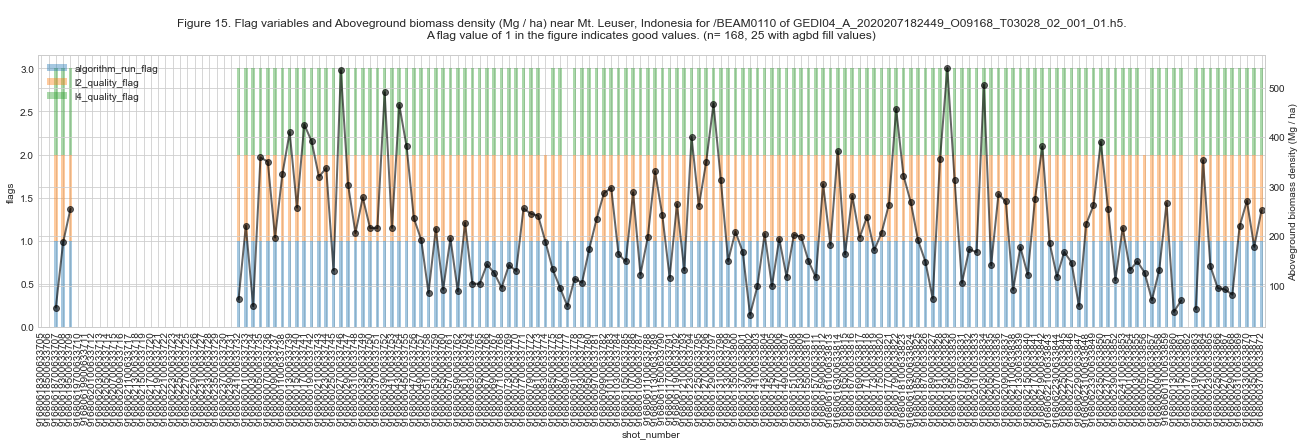

In [40]:
# plot flags as stacked bar diagram
ax = leuser_gdf.plot(y=['algorithm_run_flag', 'l2_quality_flag','l4_quality_flag'], alpha=0.4, 
                     kind='bar', figsize=(22, 5), stacked=True, use_index=True,legend=True)
# plot agbd in the secondary y-axis as line
ax2 = ax.twinx()
ax2.plot(leuser_gdf[['agbd']].values, linestyle='-', alpha=0.6, marker='o', linewidth=2.0, color ='black')
# figure title
fig_n += 1
ax.set_title(f'''
Figure {fig_n}. Flag variables and {ylabel} near Mt. Leuser, Indonesia for {beam0110.name} of {l4a}.
A flag value of 1 in the figure indicates good values. (n= {str(len(leuser_gdf.index))}, {len(leuser_gdf[leuser_gdf['agbd'].isnull()].index)} with agbd fill values)
''')
# labels
ax.set_ylabel("flags")
ax2.set_ylabel(ylabel)

The `algorithm_run_flag` set is set to 1 when the shot quality is good to run the GEDIL4_A algorithm. When the algorithm is not run for the shot (indicated by `algorithm_run_flag`=0), all the AGBD variables will be set to the fill values (-9999). The `l2_quality_flag` identifies shots with good GEDI L2A quality metrics for the prediction of AGBD. The `l4_quality_flag` identifies shots that are representative of the applied AGBD models. Let's apply both `l2_quality_flag` and `l4_quality_flag` to the dataframe. 

In [41]:
leuser_gdf = leuser_gdf[(leuser_gdf['l2_quality_flag'] == 1) & (leuser_gdf['l4_quality_flag'] == 1)]

# close the GEDI L4A HDF file 
hf.close()

Now, the dataframe `leuser_gdf` contains all the rows where both `l2_quality_flag` and `l4_quality_flag` filters are applied. Refer to the [GEDI L4A ATBD](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_ATBD_L4A_v1.0.pdf) and [GEDI L4A Common Queries](https://daac.ornl.gov/daacdata/gedi/GEDI_L4A_AGB_Density/comp/GEDI_L4A_Common_Queries.pdf) documents for more details about the quality flags.

## 11. Final Note
As we saw in this tutorial, in addition to AGBD estimates, a GEDI L4A file has information about predictor variables from the lower level GEDI products and other associated variables derived from multiple sensors such as MODIS, VIIRS, TanDEM-X, and Landsat, among others. GEDI generates ~15-16 orbits each day. The current dataset consists of 504 days of GEDI shots, which has collected more than 25 billion shots during this period. GEDI is still collecting data every day and will do so for the next few years, which is an immense amount of data at our hands. 